In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.initializers import RandomNormal, Constant

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, QuantileTransformer, RobustScaler, StandardScaler,MinMaxScaler
from tensorflow.keras.optimizers  import Adam, Adagrad, SGD, RMSprop

from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split 

import fairness_helpers as fh
import utilities
import global_variables as gv

import shap

#### load data

In [2]:
df = pd.read_csv('data/binary_full.csv')
pd.set_option('display.max_columns', None)
df.drop('Unnamed: 0', axis=1, inplace=True)

#### retreive model

In [39]:
model = keras.models.load_model('saved_models/mlp_binary_1.h5')
model.compile(loss='binary_crossentropy', #categorical_hinge
              optimizer=SGD(learning_rate=0.0005),
              metrics=['acc',tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

#### split data and predict probabilities on test dataset

In [40]:
_,  X_test, _, y_test = utilities.process_features(df, 'CVD', RobustScaler(), one_hot=True, val=False, test_size=0.3)

y_prob = model.predict(X_test) # outputs probablity assigned to Class 1
y_prob

4711/4711 [==============================] - 19s 4ms/step


array([[0.50978285],
       [0.5965653 ],
       [0.6105521 ],
       ...,
       [0.5338432 ],
       [0.26935902],
       [0.5914589 ]], dtype=float32)

In [26]:
one_count=0
zero_count=0
one_total=0
zero_total=0
for i, val in zip(y_test, y_prob):
    if i == 1:
        one_count+=1
        one_total+=val
    elif i==0:
        zero_count+=1
        zero_total+=val

print(one_total/one_count)
print(zero_total/zero_count)

[0.5731583]
[0.42829001]


#### some functions to evaluate model predictions

In [27]:
def confusion_eval(model, X_test, y_test, threshold=0.5):
    """
    Takes in model, testing data, and decision threshold and outputs prediction performance (confusion matrix,
    sensitivity, specificity, and accuracy)
    """
    y_predicted = (model.predict(X_test) >= threshold)

    conf_mat = confusion_matrix(y_test, y_predicted)
    print(conf_mat)
    total = sum(sum(conf_mat))
    sensitivity = conf_mat[0, 0]/(conf_mat[0, 0] + conf_mat[1, 0])
    specificity = conf_mat[1, 1]/(conf_mat[1, 1] + conf_mat[0, 1])
    accuracy = (conf_mat[0, 0] + conf_mat[1, 1])/total

    print('specificity : ', specificity)
    print('sensitivity : ', sensitivity)
    print('accuracy : ', accuracy)
    return conf_mat, sensitivity, specificity, accuracy

### let's figure out the best threshold to minimize false negatives!

> Since this problem is a case of medical diagnostics, we care way more about correctly diagnosing the people who actually have CVDs so that they can get treatment, therefore we are willing to allow a few more false positive cases to ensure the best ultimate health outcomes for everyone. (focus on maximizing Sensitivity)

#### optimal threshold for ROC Curve

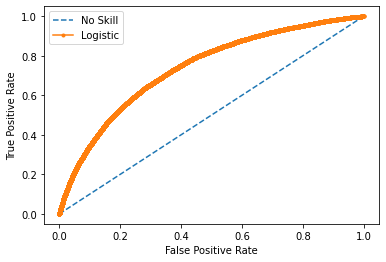

In [28]:
# calculate scores
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

#### PR Curve: focus on minority class

In [45]:
test_thresholds=np.arange(0,1,0.05)
df_results = pd.DataFrame(columns = ['threshold', 'specificity', 'sensitivity', 'accuracy'])
for threshold in test_thresholds:
    mat, sens,spec, acc = confusion_eval(model, X_test, y_test, threshold=threshold)
    
    df_new = pd.DataFrame({'threshold':threshold, 'specificity':spec, 'sensitivity':sens, 'accuracy':acc}, index=[0])
    df_results = pd.concat([df_results,df_new])

4711/4711 [==============================] - 21s 4ms/step
[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
   1/4711 [..............................] - ETA: 2:47

invalid value encountered in longlong_scalars


4711/4711 [==============================] - 20s 4ms/step
[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
   1/4711 [..............................] - ETA: 2:44

invalid value encountered in longlong_scalars


4711/4711 [==============================] - 22s 5ms/step
[[    14 136654]
 [     0  14077]]
specificity :  0.0933915385687085
sensitivity :  1.0
accuracy :  0.0934757371720455
4711/4711 [==============================] - 27s 6ms/step
[[  1288 135380]
 [    30  14047]]
specificity :  0.09400576870311256
sensitivity :  0.9772382397572079
accuracy :  0.10172808385021062
4711/4711 [==============================] - 27s 6ms/step
[[  8131 128537]
 [   138  13939]]
specificity :  0.0978340211684775
sensitivity :  0.9833111621719676
accuracy :  0.14640618262628943
4711/4711 [==============================] - 25s 5ms/step
[[ 20314 116354]
 [   450  13627]]
specificity :  0.10483839945838237
sensitivity :  0.978327875168561
accuracy :  0.22515506318617534
4711/4711 [==============================] - 26s 5ms/step
[[ 34997 101671]
 [   913  13164]]
specificity :  0.11463404014455524
sensitivity :  0.9745753272069062
accuracy :  0.3194865501343328
4711/4711 [==============================] - 25s 5

invalid value encountered in longlong_scalars


In [46]:
df_results

,threshold,specificity,sensitivity,accuracy
0,0.00,0.093383,NaN,0.093383
0,0.05,0.093383,NaN,0.093383
0,0.10,0.093392,1.000000,0.093476
0,0.15,0.094006,0.977238,0.101728
0,0.20,0.097834,0.983311,0.146406
0,0.25,0.104838,0.978328,0.225155
0,0.30,0.114634,0.974575,0.319487
0,0.35,0.126767,0.970966,0.415132
0,0.40,0.141281,0.966060,0.509317
0,0.45,0.158477,0.960799,0.596338


#### plot threshold results

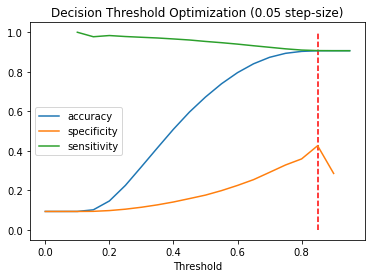

In [52]:
# plot lines
plt.plot(df_results['threshold'], df_results['accuracy'], label = "accuracy")
plt.plot(df_results['threshold'], df_results['specificity'], label = "specificity")
plt.plot(df_results['threshold'], df_results['sensitivity'], label = "sensitivity")
# single line
plt.vlines(x = 0.85, ymin = 0, ymax = 1.0,
           colors = 'red',
           linestyle='--')
plt.legend(loc='center left')
plt.title('Decision Threshold Optimization (0.05 step-size)')
plt.xlabel('Threshold')
plt.savefig('charts/models/MLP/mlp_threshold.png', bbox_inches='tight')
plt.show()

#### build SHAP explainer

In [ ]:
explainer = shap.KernelExplainer(model.predict,X_train)


## XGBoost Model

## TabNet Model